In [1]:
# Εργασία Classification - Αναγνώριση Χρεωκοπίας Εταιρειών
# Google Colab Notebook

In [2]:
# 1. Εισαγωγή βιβλιοθηκών
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [20]:
# 2. Ανάγνωση αρχείου Excel
# ================================
from google.colab import files
import pandas as pd

uploaded = files.upload()  # Ο χρήστης ανεβάζει το αρχείο

# Ανάγνωση του Excel αρχείου
for filename in uploaded.keys():
    df = pd.read_excel(filename)
    print(f"Το αρχείο '{filename}' φορτώθηκε επιτυχώς.")
    break  # Χρησιμοποιούμε μόνο το πρώτο αρχείο

Saving Dataset2Use_Assignment1.xlsx to Dataset2Use_Assignment1.xlsx
Το αρχείο 'Dataset2Use_Assignment1.xlsx' φορτώθηκε επιτυχώς.


In [21]:
# 3. Έλεγχος για NaNs
# ================================
if df.isnull().values.any():
    print("ΠΡΟΕΙΔΟΠΟΙΗΣΗ: Υπάρχουν ελλιπείς εγγραφές!")
else:
    print("Τα δεδομένα δεν περιέχουν ελλιπείς τιμές.")

Τα δεδομένα δεν περιέχουν ελλιπείς τιμές.


In [22]:
# 4. Ορισμός στηλών
# ================================
performance_cols = df.columns[0:8]  # Στήλες Α–Η
activity_cols = df.columns[8:11]    # Στήλες I–K
status_col = df.columns[11]         # Κατάσταση
year_col = df.columns[12]           # Έτος

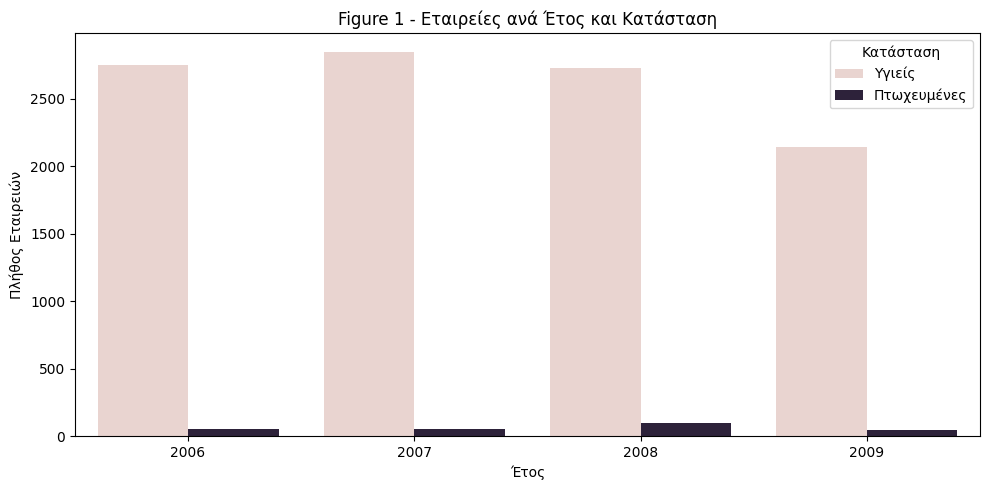

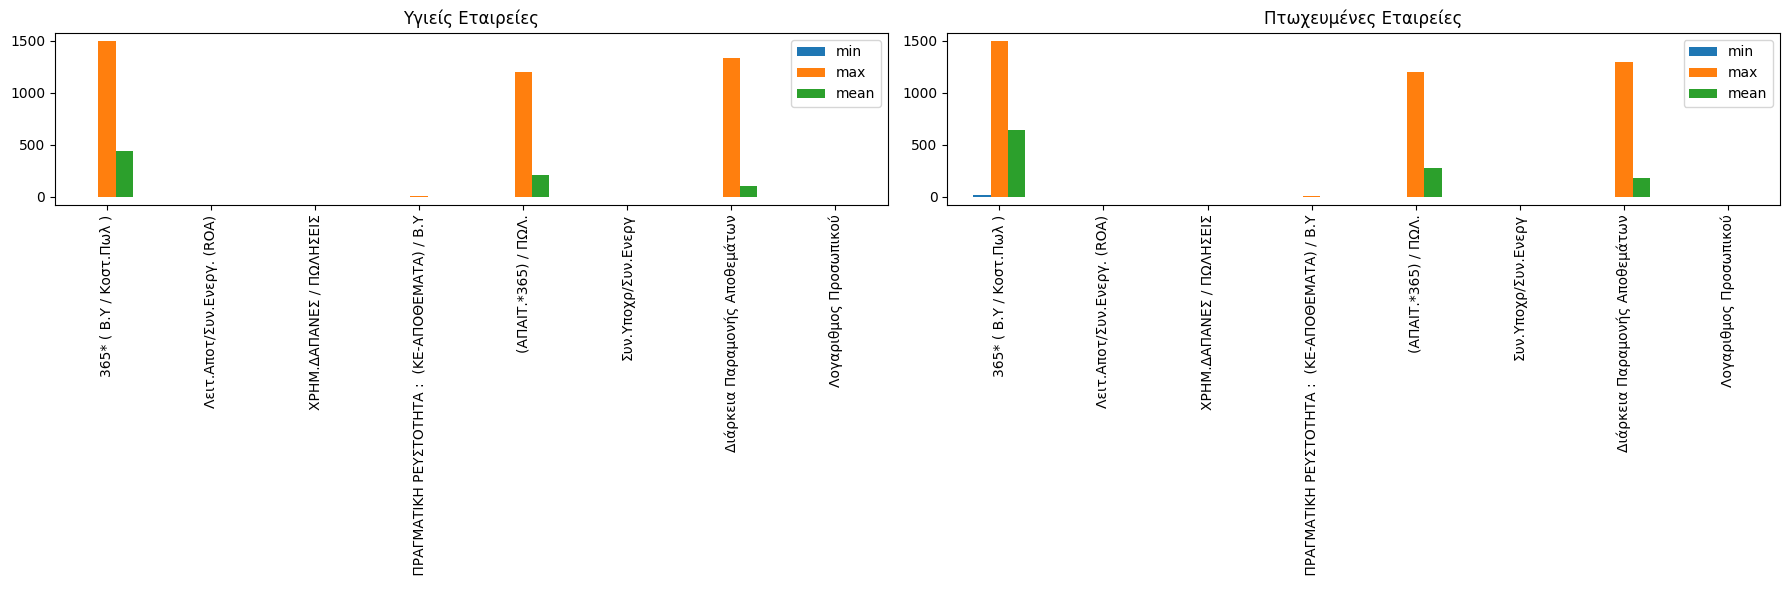

In [23]:
# 5. Γραφήματα (Figure 1 & 2)
# ================================
# Figure 1
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x=year_col, hue=status_col)
plt.title('Figure 1 - Εταιρείες ανά Έτος και Κατάσταση')
plt.xlabel('Έτος')
plt.ylabel('Πλήθος Εταιρειών')
plt.legend(title='Κατάσταση', labels=['Υγιείς', 'Πτωχευμένες'])
plt.tight_layout()
plt.show()

# Figure 2
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
healthy = df[df[status_col] == 1][performance_cols]
bankrupt = df[df[status_col] == 2][performance_cols]

healthy.agg(['min', 'max', 'mean']).T.plot(kind='bar', ax=axs[0], title='Υγιείς Εταιρείες')
bankrupt.agg(['min', 'max', 'mean']).T.plot(kind='bar', ax=axs[1], title='Πτωχευμένες Εταιρείες')
plt.tight_layout()
plt.show()

In [16]:
# 6. Κανονικοποίηση [0,1]
# ================================
scaler = MinMaxScaler()
df[performance_cols] = scaler.fit_transform(df[performance_cols])


===== Fold 1 =====
Train set: Υγιείς: 7851, Πτωχευμένες: 186
Test set: Υγιείς: 2617, Πτωχευμένες: 62
[BALANCED] Train set: Υγιείς: 558, Πτωχευμένες: 186


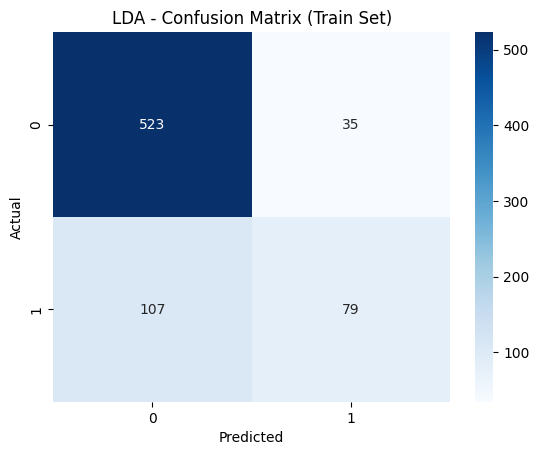

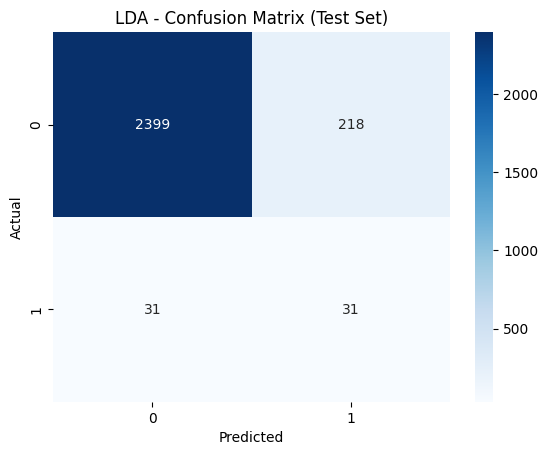

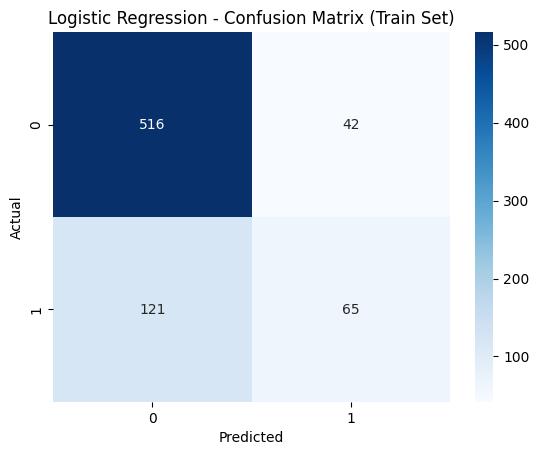

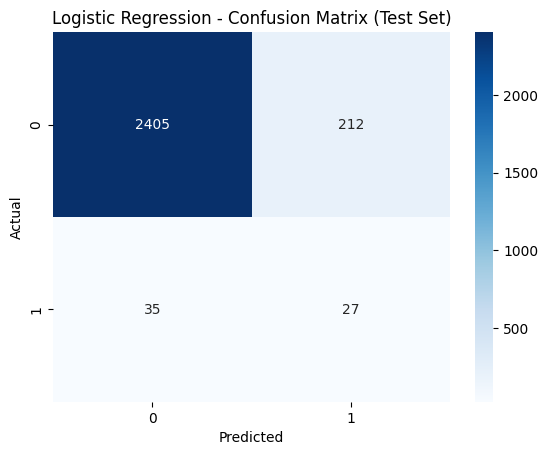

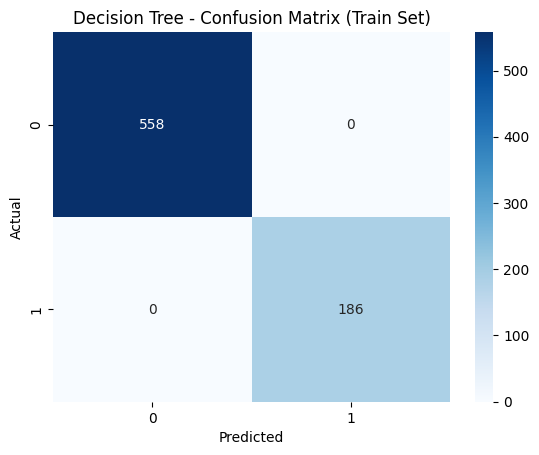

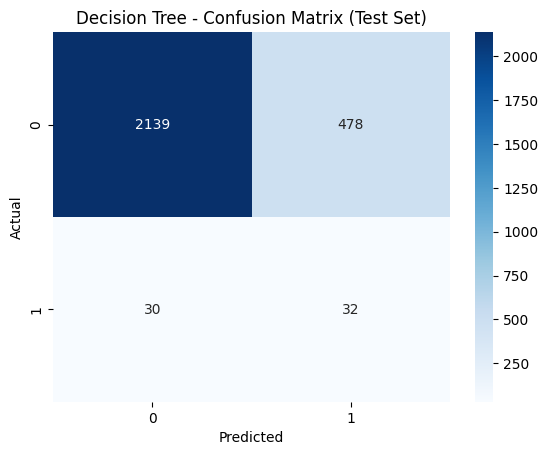

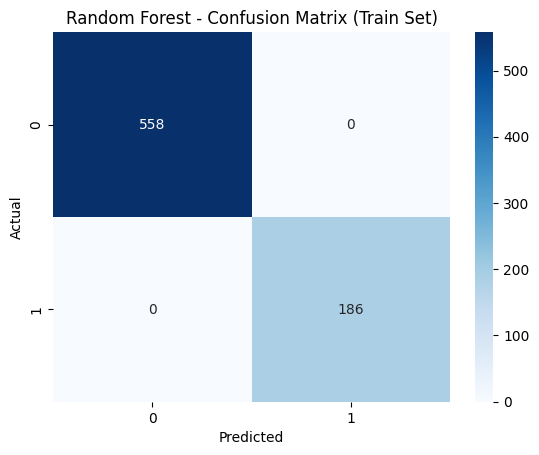

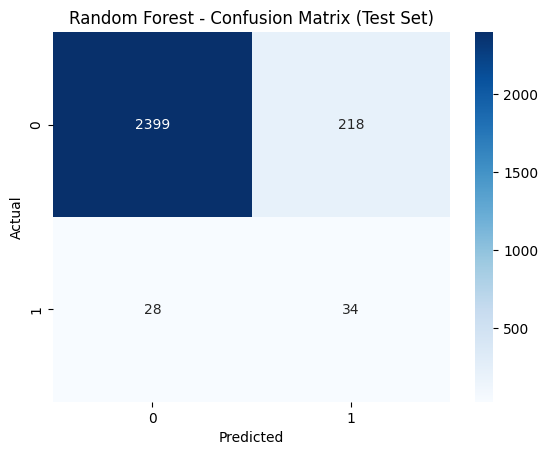

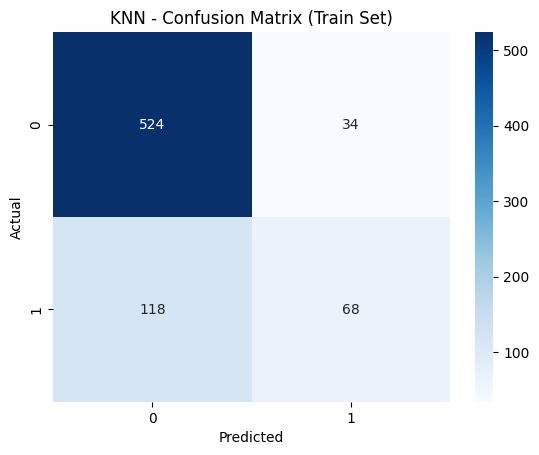

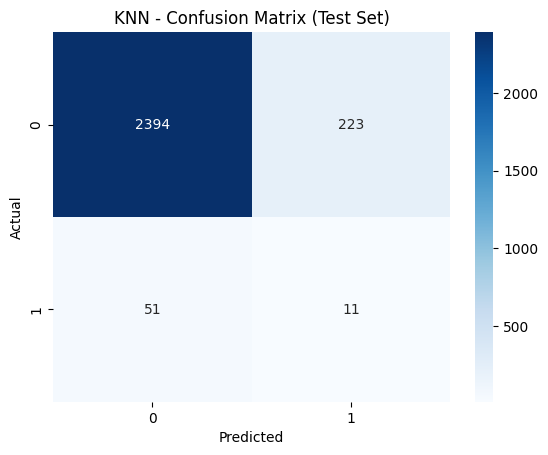

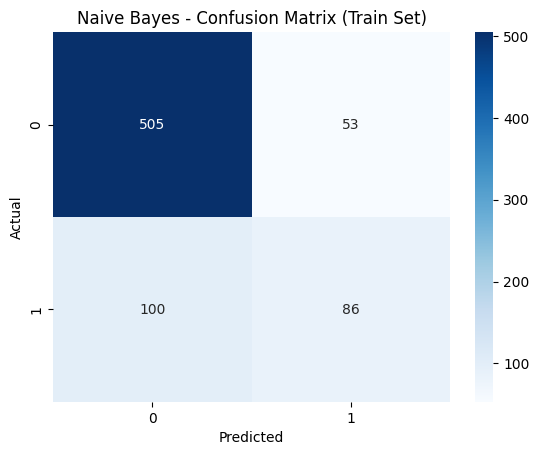

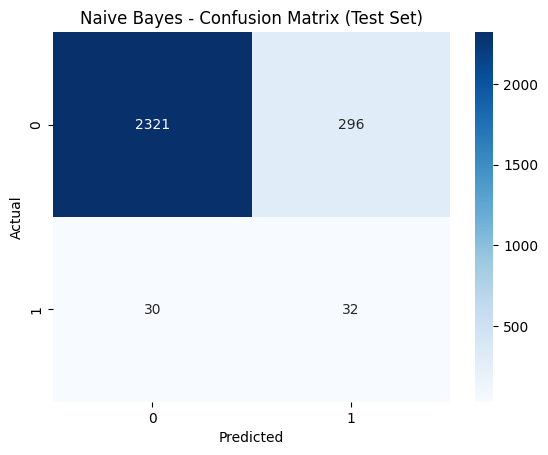

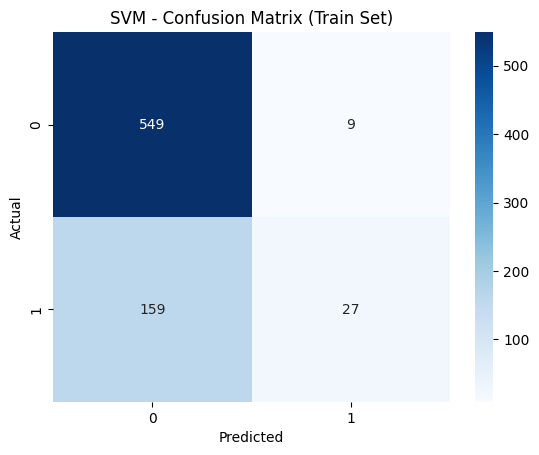

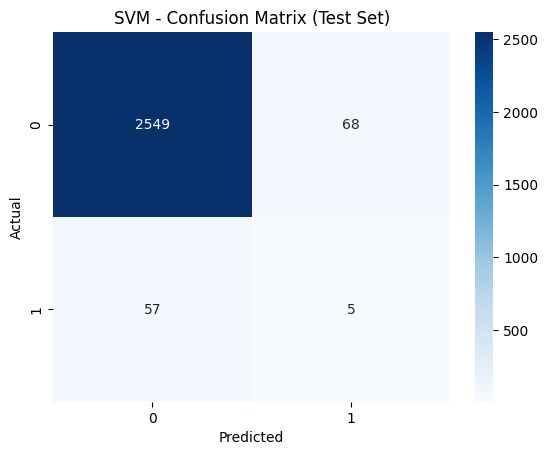

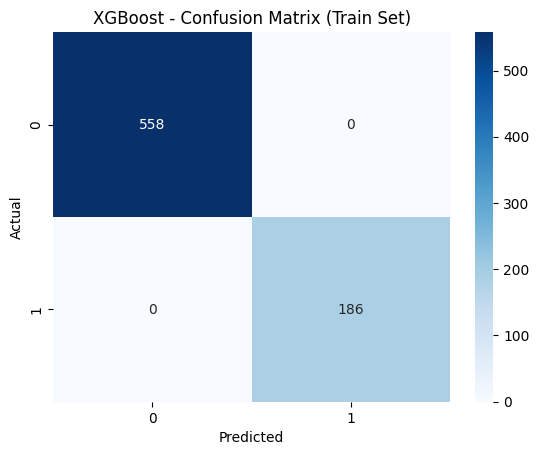

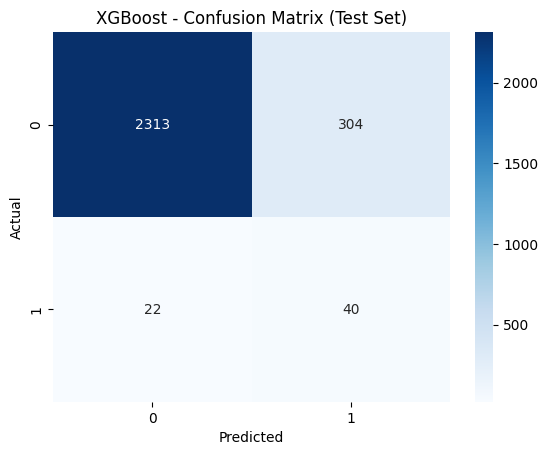


===== Fold 2 =====
Train set: Υγιείς: 7851, Πτωχευμένες: 186
Test set: Υγιείς: 2617, Πτωχευμένες: 62
[BALANCED] Train set: Υγιείς: 558, Πτωχευμένες: 186


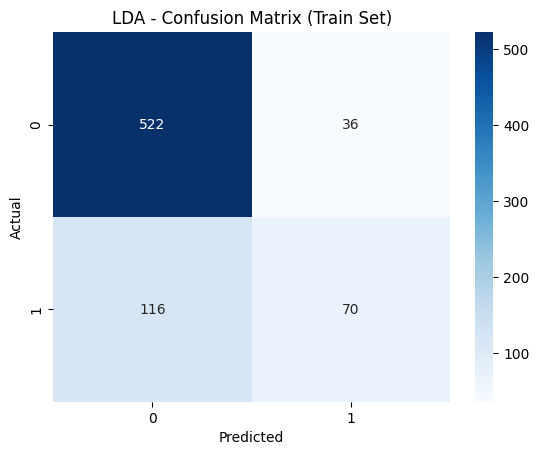

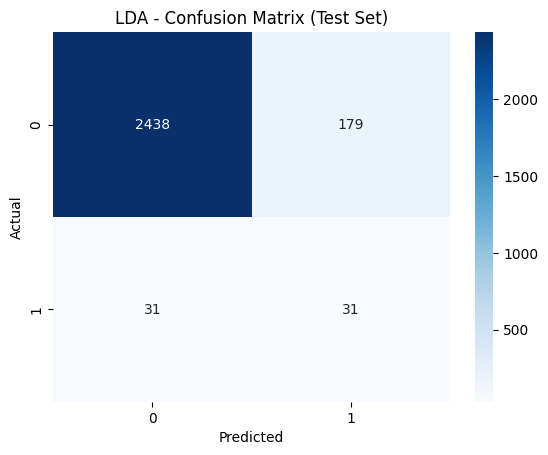

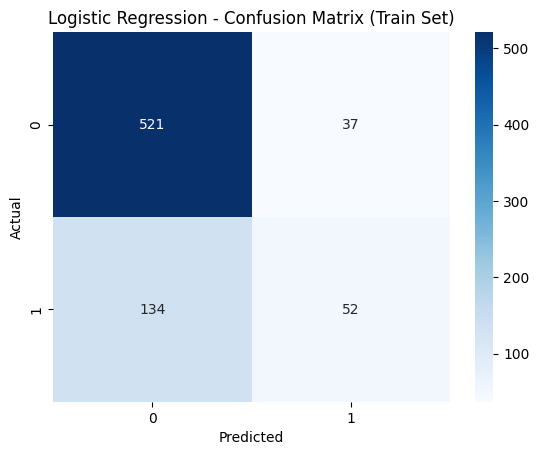

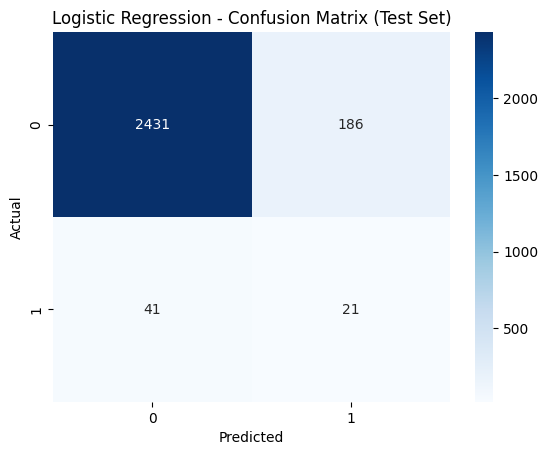

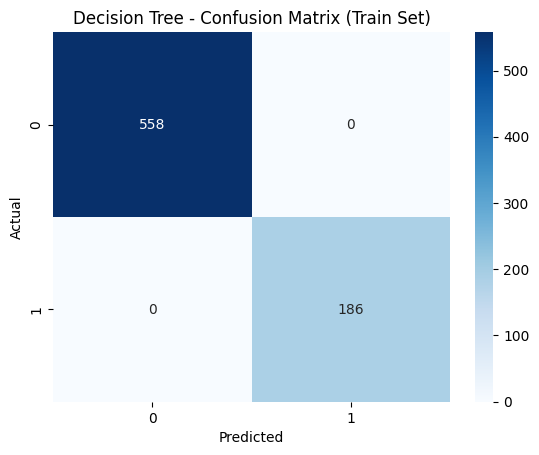

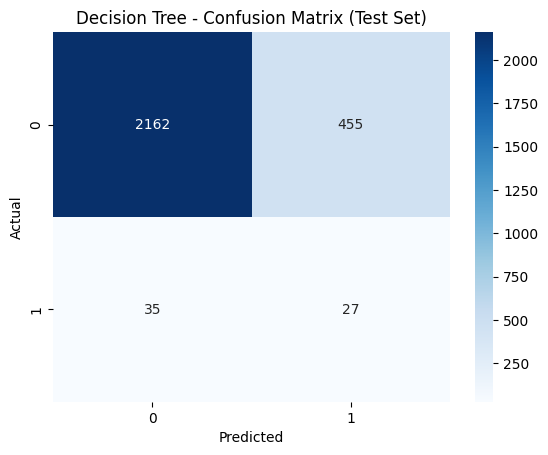

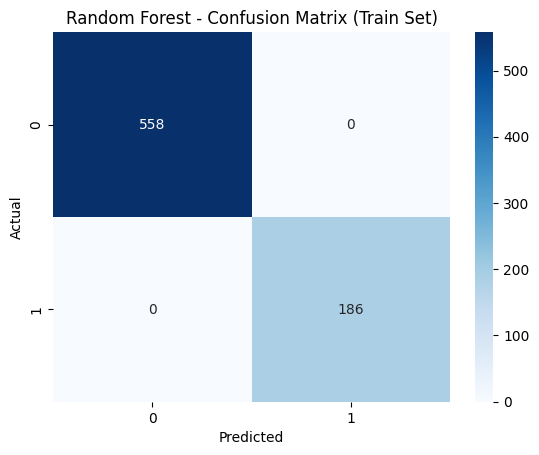

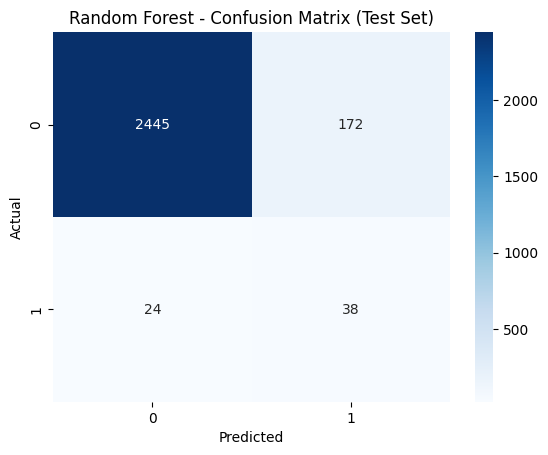

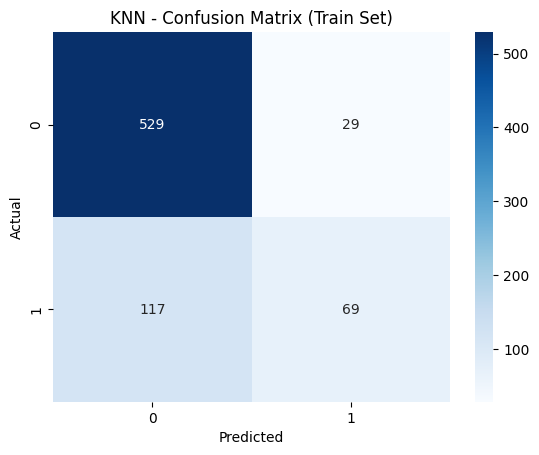

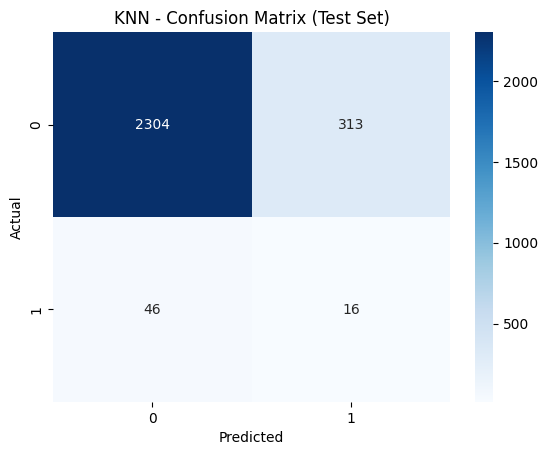

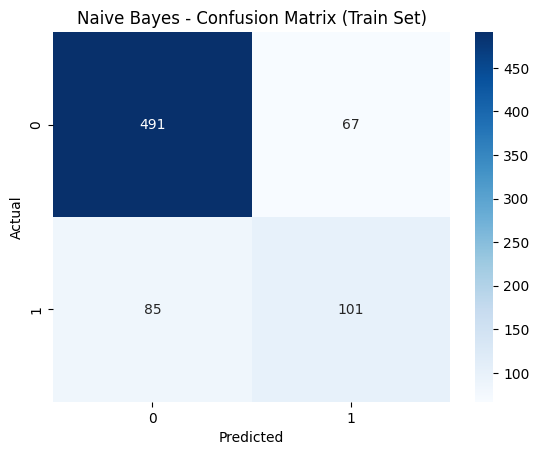

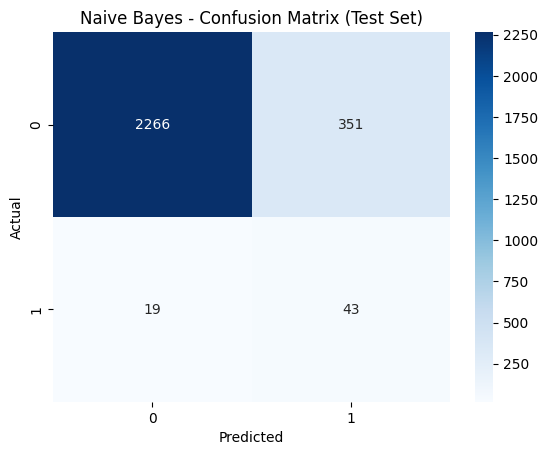

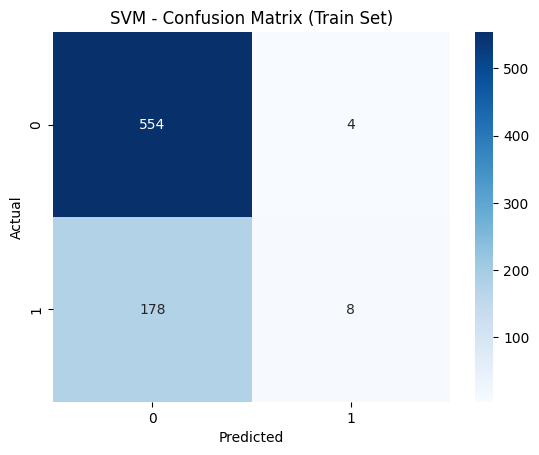

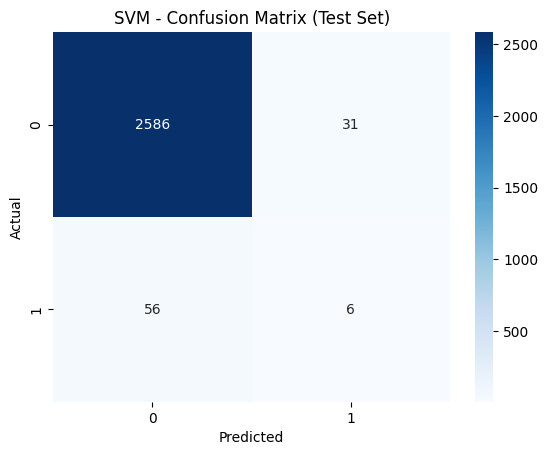

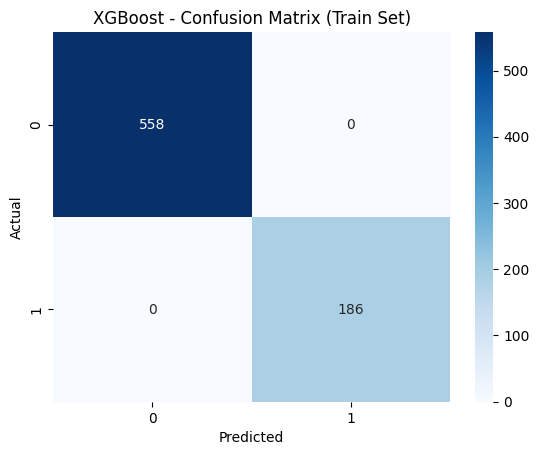

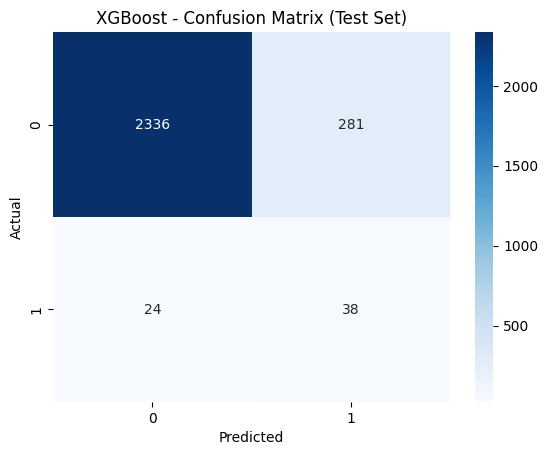


===== Fold 3 =====
Train set: Υγιείς: 7851, Πτωχευμένες: 186
Test set: Υγιείς: 2617, Πτωχευμένες: 62
[BALANCED] Train set: Υγιείς: 558, Πτωχευμένες: 186


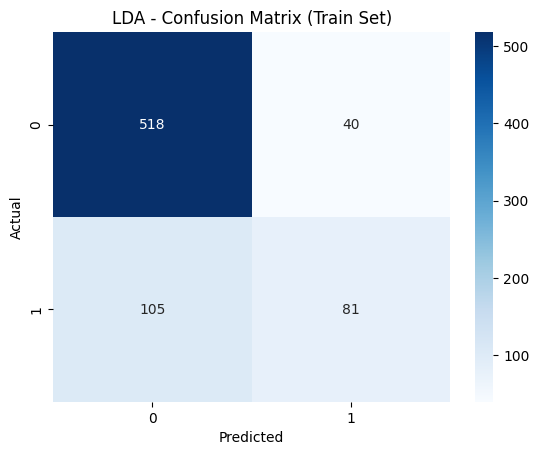

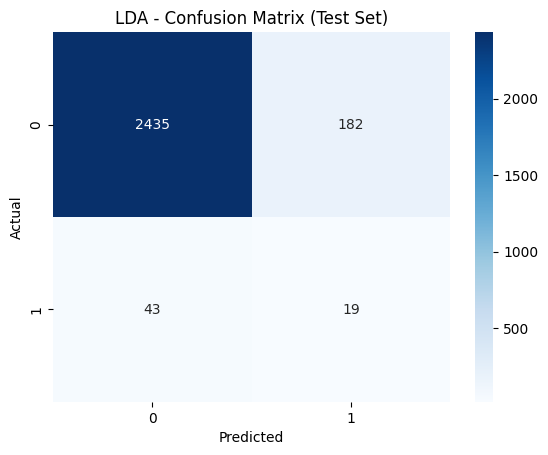

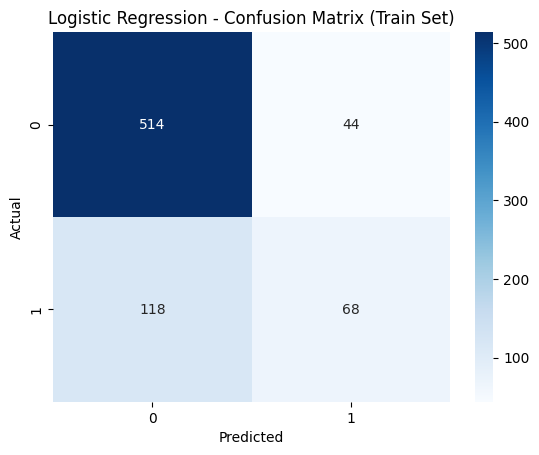

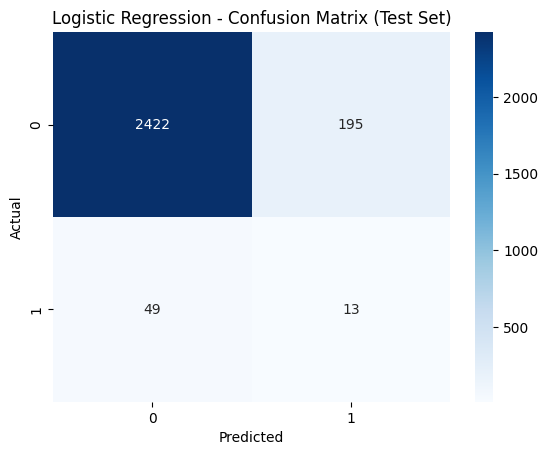

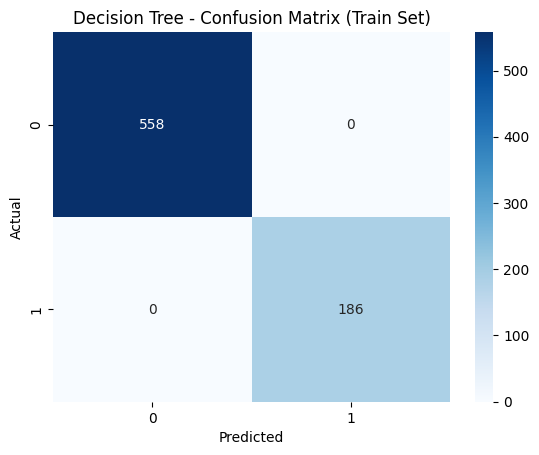

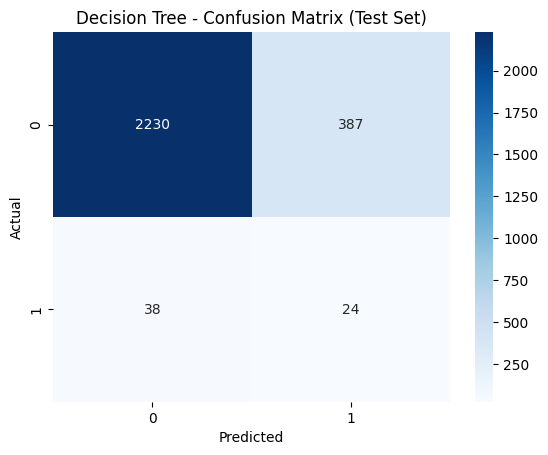

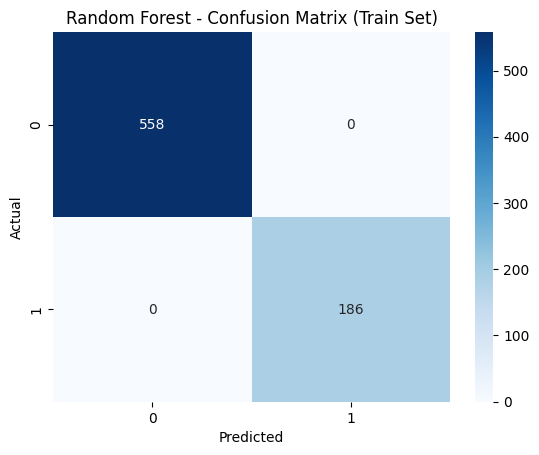

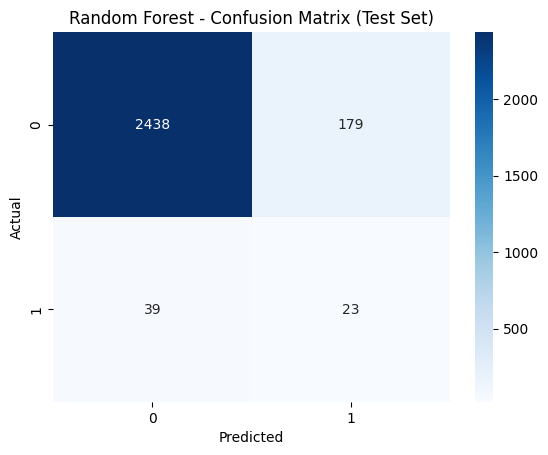

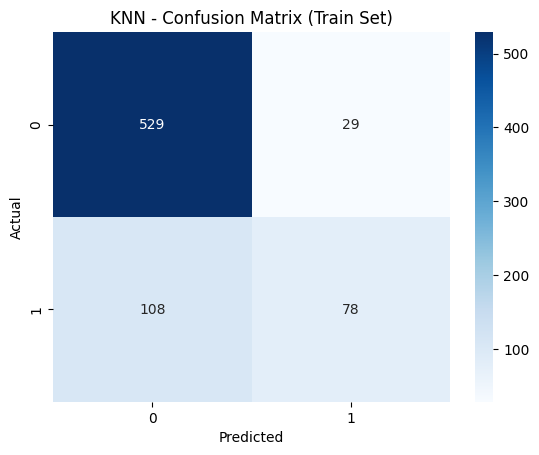

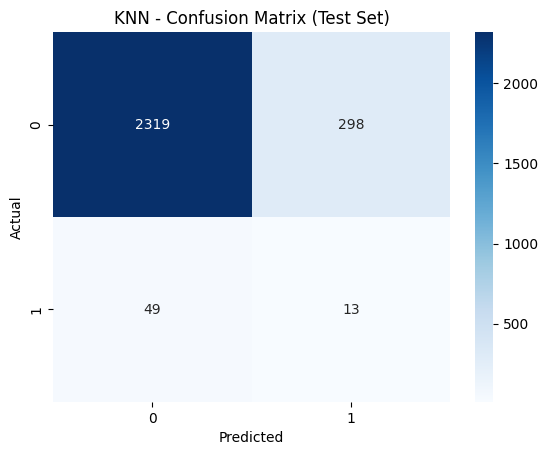

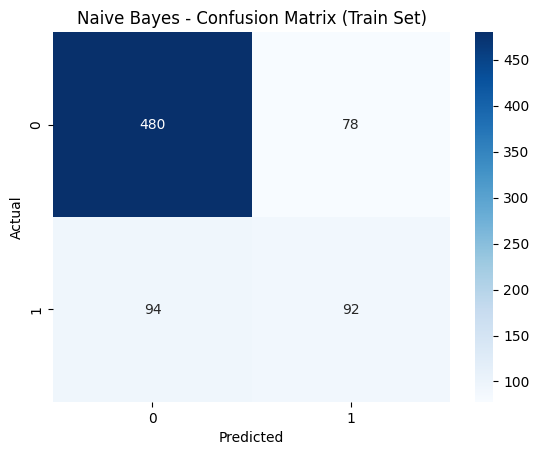

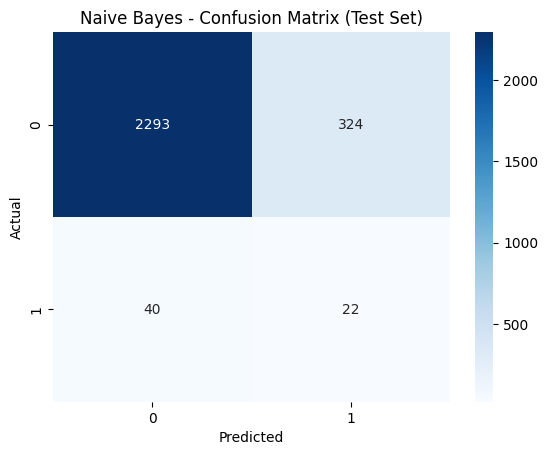

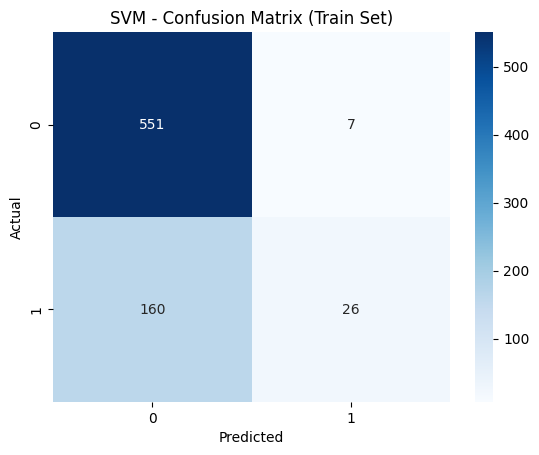

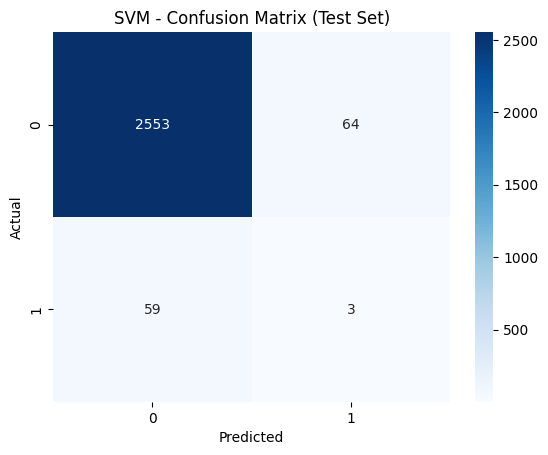

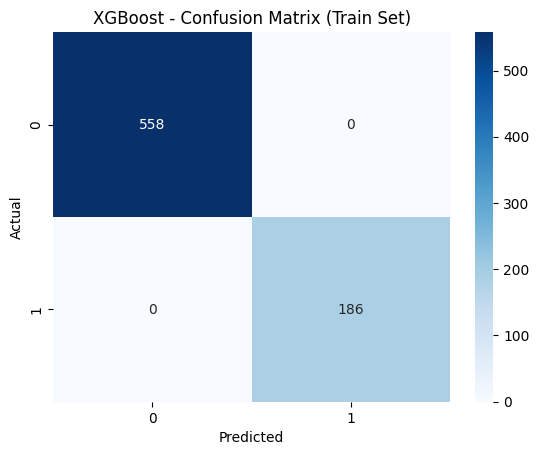

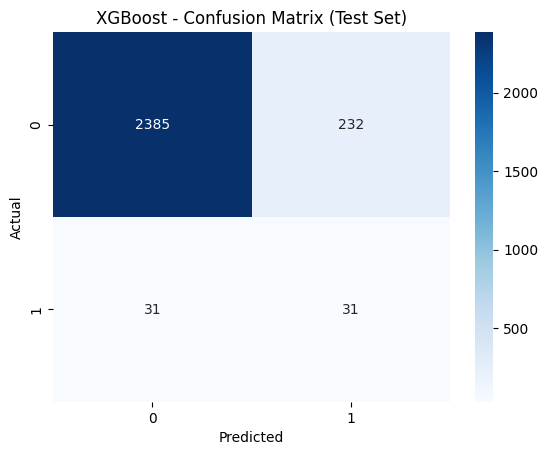


===== Fold 4 =====
Train set: Υγιείς: 7851, Πτωχευμένες: 186
Test set: Υγιείς: 2617, Πτωχευμένες: 62
[BALANCED] Train set: Υγιείς: 558, Πτωχευμένες: 186


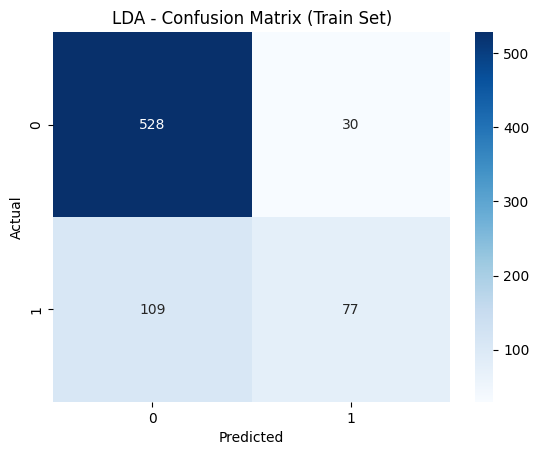

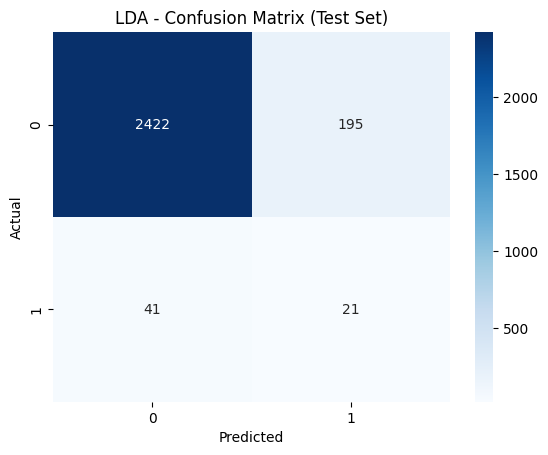

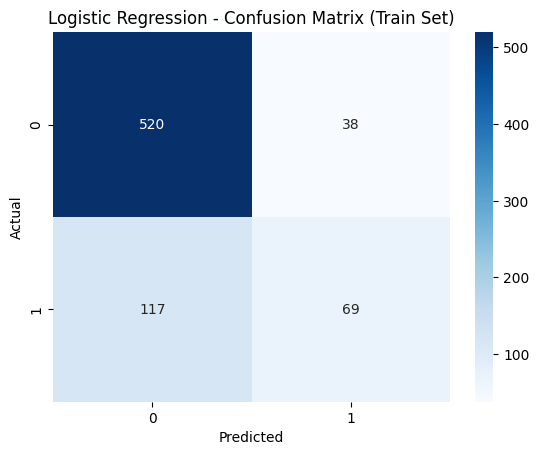

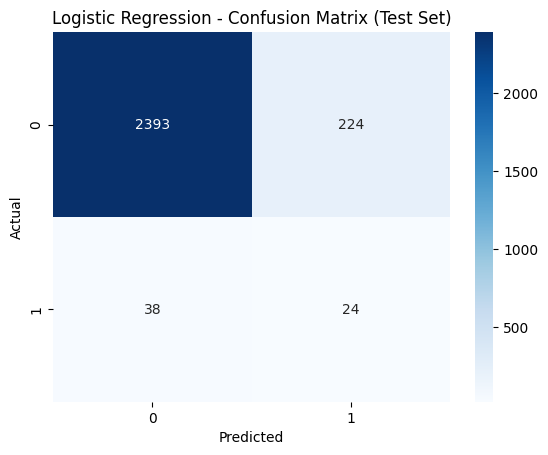

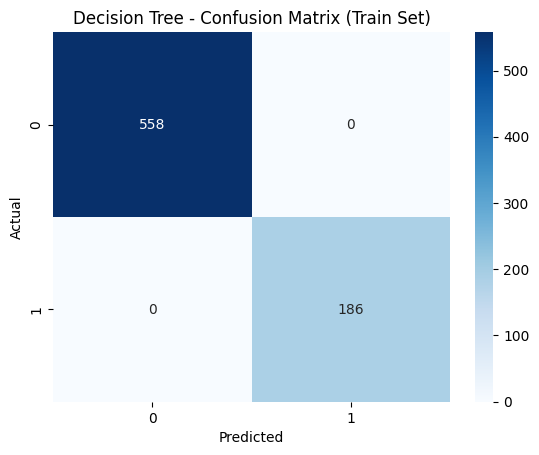

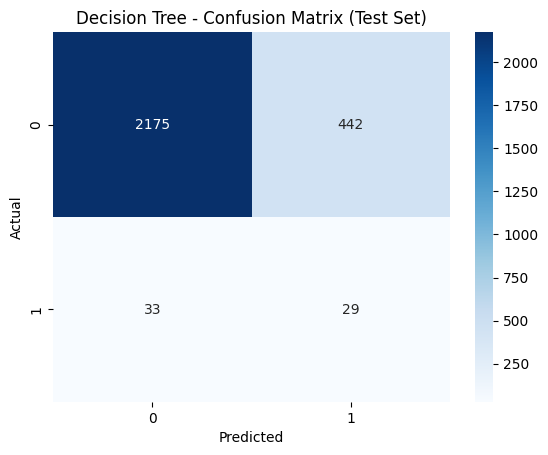

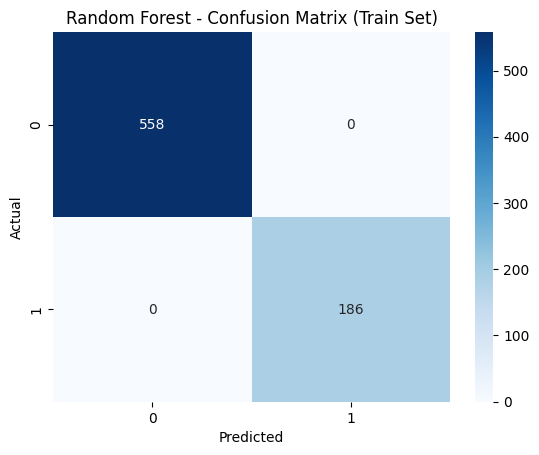

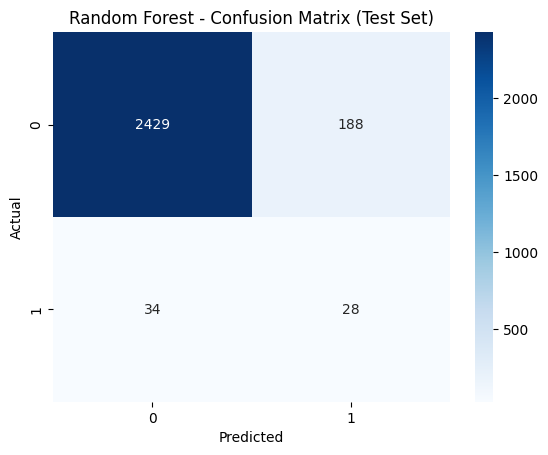

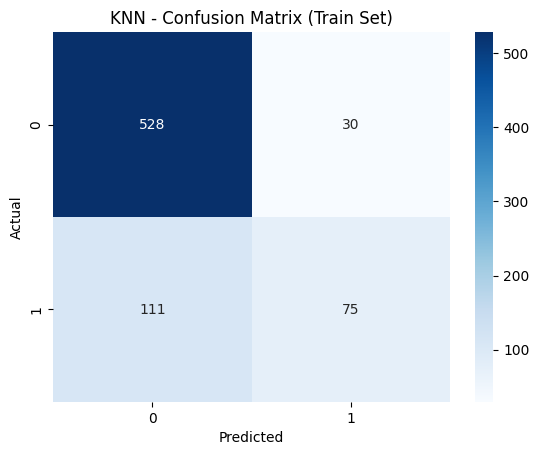

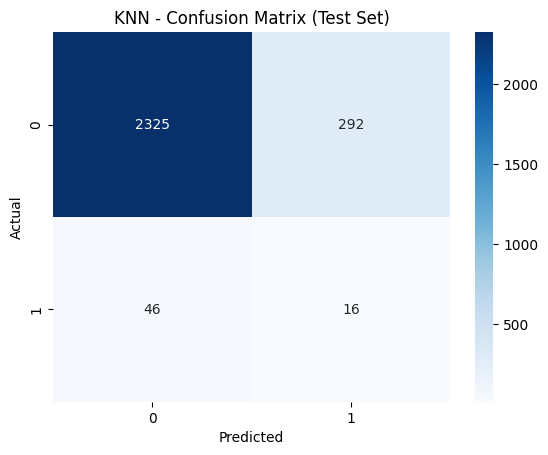

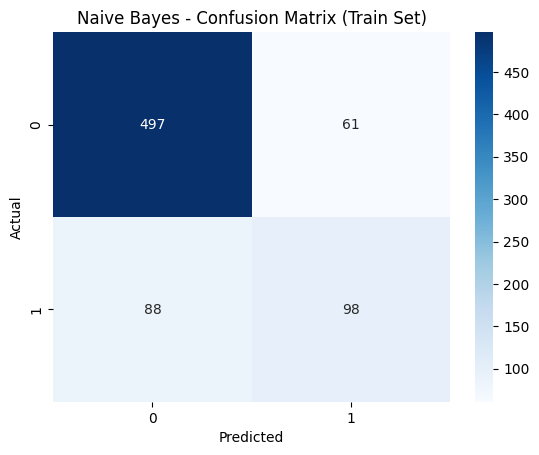

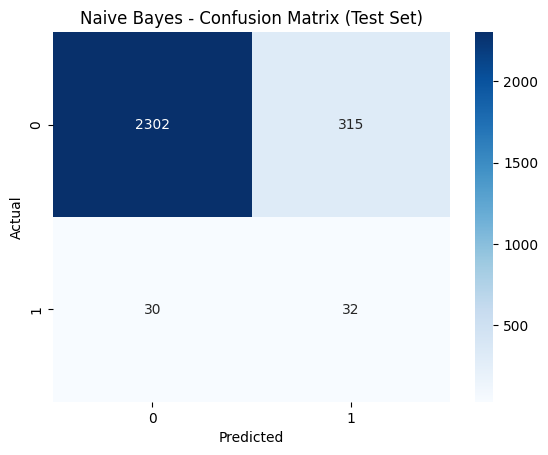

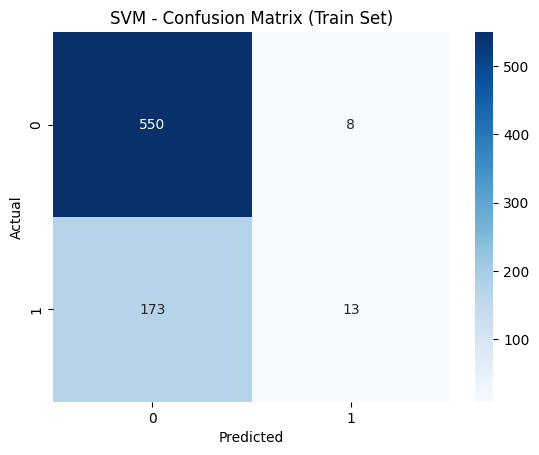

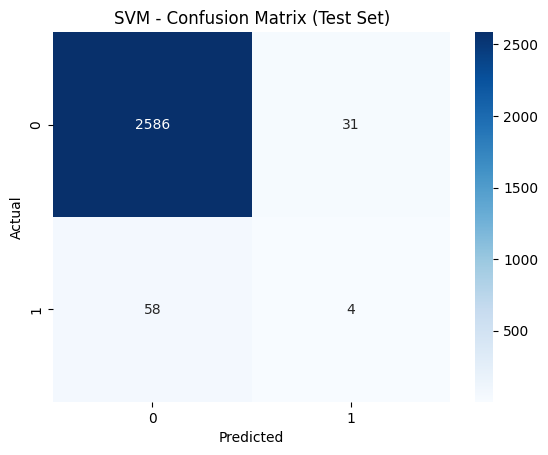

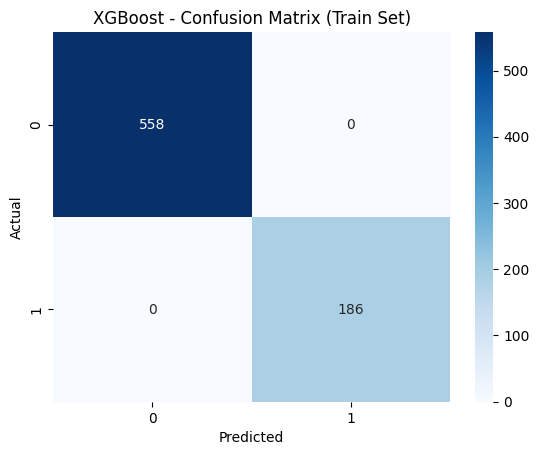

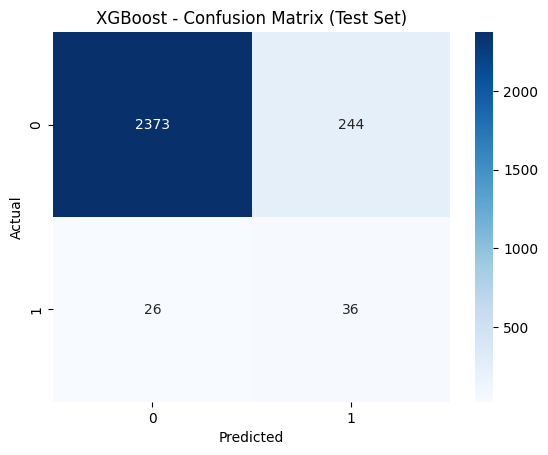

In [24]:
# 7. Stratified K-Fold και Εκπαίδευση
# ================================
X = df[performance_cols.tolist() + activity_cols.tolist()]
y = df[status_col].replace({1: 0, 2: 1})  # 0: Υγιείς, 1: Πτωχευμένες
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

models = {
    'LDA': LinearDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n===== Fold {fold} =====")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"Train set: Υγιείς: {(y_train==0).sum()}, Πτωχευμένες: {(y_train==1).sum()}")
    print(f"Test set: Υγιείς: {(y_test==0).sum()}, Πτωχευμένες: {(y_test==1).sum()}")

    ratio = (y_train==0).sum() / (y_train==1).sum()
    if ratio > 3:
        healthy_df = X_train[y_train == 0]
        bankrupt_df = X_train[y_train == 1]
        y_healthy = y_train[y_train == 0]
        y_bankrupt = y_train[y_train == 1]

        healthy_sample = resample(healthy_df, replace=False, n_samples=3*len(bankrupt_df), random_state=42)
        y_healthy_sample = y_healthy.loc[healthy_sample.index]

        X_train = pd.concat([healthy_sample, bankrupt_df])
        y_train = pd.concat([y_healthy_sample, y_bankrupt])

    print(f"[BALANCED] Train set: Υγιείς: {(y_train==0).sum()}, Πτωχευμένες: {(y_train==1).sum()}")

    for name, model in models.items():
        model.fit(X_train, y_train)
        for dataset, X_set, y_set, label in [("train", X_train, y_train, "Train"), ("test", X_test, y_test, "Test")]:
            y_pred = model.predict(X_set)
            y_prob = model.predict_proba(X_set)[:,1] if hasattr(model, "predict_proba") else None
            cm = confusion_matrix(y_set, y_pred)
            acc = accuracy_score(y_set, y_pred)
            prec = precision_score(y_set, y_pred, pos_label=1)
            rec = recall_score(y_set, y_pred, pos_label=1)
            f1 = f1_score(y_set, y_pred, pos_label=1)
            roc = roc_auc_score(y_set, y_prob) if y_prob is not None else np.nan

            TP, FN = cm[1,1], cm[1,0]
            TN, FP = cm[0,0], cm[0,1]

            results.append({
                'Classifier Name': name,
                'Training or test set': dataset,
                'Balanced or unbalanced train set': 'balanced',
                'Number of training samples': len(y_train),
                'Number of non-healthy companies in training sample': (y_train==1).sum(),
                'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
                'ROC-AUC': round(roc, 2),
                'Accuracy': round(acc, 2),
                'Precision': round(prec, 2),
                'Recall': round(rec, 2),
                'F1': round(f1, 2)
            })

            plt.figure()
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"{name} - Confusion Matrix ({label} Set)")
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

In [25]:
# 8. Εξαγωγή αποτελεσμάτων σε CSV
# ================================
results_df = pd.DataFrame(results)
results_df.to_csv('balancedDataOutcomes.csv', index=False)
print("\nΑποθηκεύτηκαν τα αποτελέσματα στο balancedDataOutcomes.csv")


Αποθηκεύτηκαν τα αποτελέσματα στο balancedDataOutcomes.csv


In [26]:
# 9. Μετατροπή του CSV σε Excel (.xlsx)
# ================================
excel_path = 'balancedDataOutcomes.xlsx'
results_df.to_excel(excel_path, index=False)

print(f"Το αρχείο αποθηκεύτηκε ως {excel_path}")

Το αρχείο αποθηκεύτηκε ως balancedDataOutcomes.xlsx
